In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive

/content/drive/MyDrive


(3, 128, 128, 16)
Using slice index: image=8, DVF=8 (image depth=16, DVF depth=16)


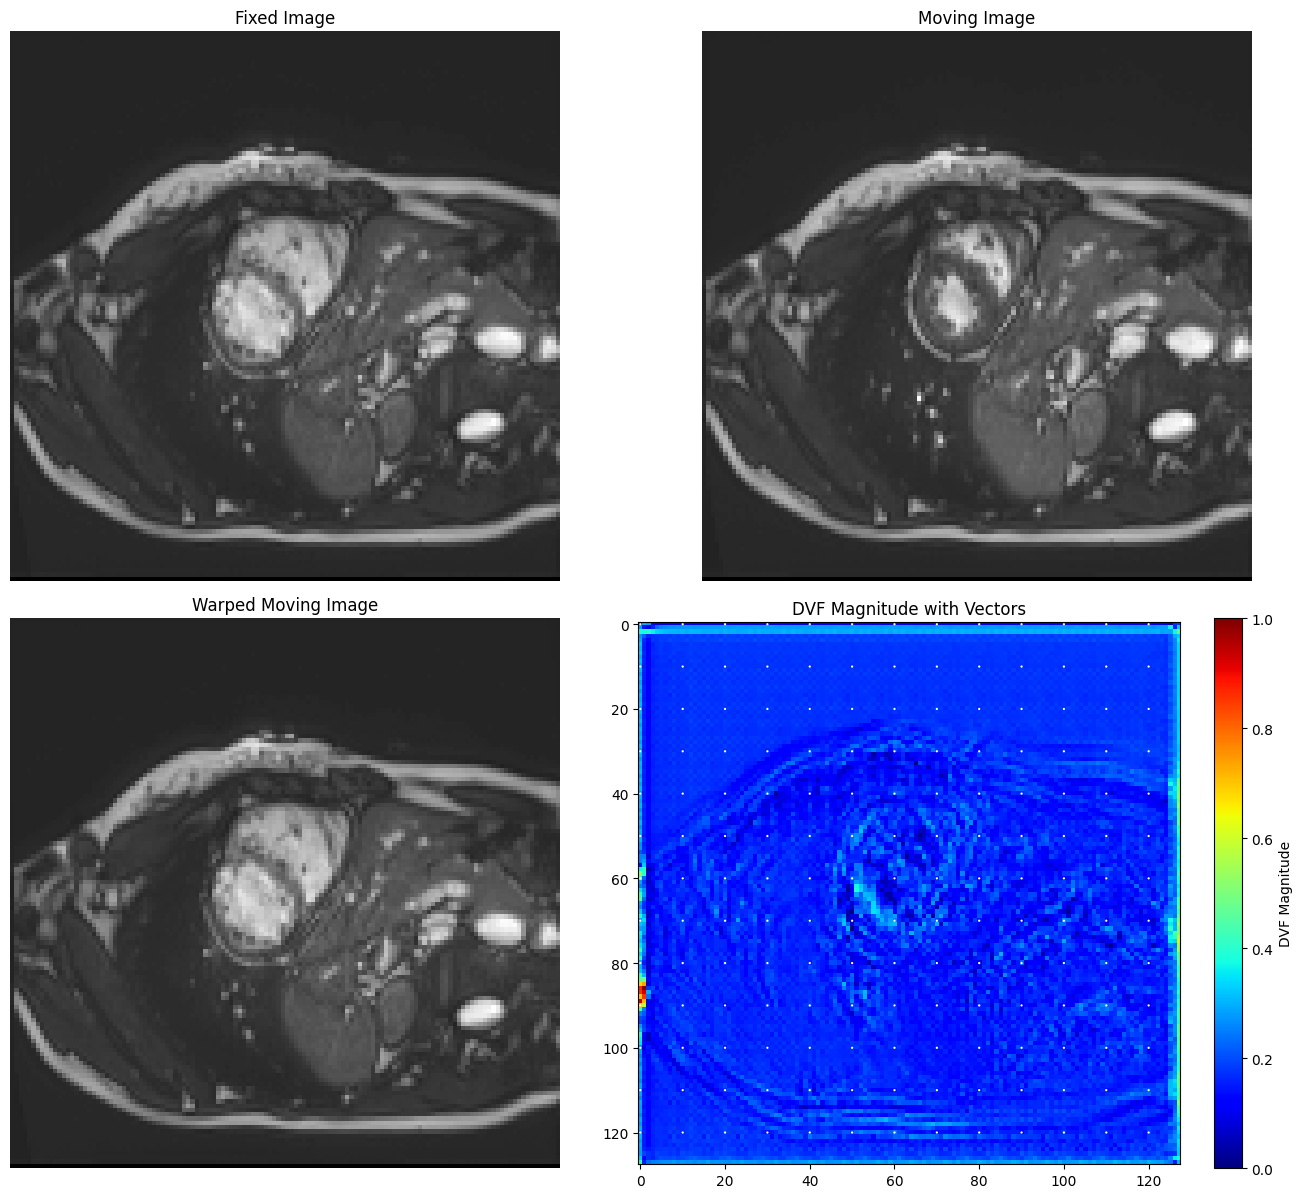

In [3]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_registration_slices_with_quiver(fixed, moving, warped, dvf, slice_idx=None, step=5):
    """
    Plot slices of fixed, moving, warped images and DVF slices with quiver arrows.

    Parameters:
        fixed: np.ndarray, fixed image volume (H, W, D)
        moving: np.ndarray, moving image volume (H, W, D)
        warped: np.ndarray, warped moving image (H, W, D)
        dvf: np.ndarray, displacement vector field, either (H, W, D, 3) or (3, H, W, D)
        slice_idx: int, optional index of slice along axis 2. If None, middle slice is used.
        step: int, step size for quiver arrows
    """

    # Automatically handle DVF shape
    if dvf.shape[0] == 3:
        # shape is (3,H,W,D) ? transpose to (H,W,D,3)
        dvf = np.transpose(dvf, (1, 2, 3, 0))

    H, W, D = fixed.shape
    _, _, D_dvf, _ = dvf.shape

    # Default: middle slice
    if slice_idx is None:
        slice_idx = D // 2

    # Map slice index to DVF depth
    dvf_slice_idx = int(slice_idx * D_dvf / D)
    dvf_slice_idx = max(0, min(dvf_slice_idx, D_dvf - 1))
    print(f"Using slice index: image={slice_idx}, DVF={dvf_slice_idx} (image depth={D}, DVF depth={D_dvf})")

    # Extract slices
    fixed_slice = fixed[:, :, slice_idx]
    moving_slice = moving[:, :, slice_idx]
    warped_slice = warped[:, :, slice_idx]

    u = dvf[:, :, dvf_slice_idx, 0]
    v = dvf[:, :, dvf_slice_idx, 1]
    w = dvf[:, :, dvf_slice_idx, 2]

    dvf_mag = np.sqrt(u**2 + v**2 + w**2)

    # Plot images
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    axes[0,0].imshow(fixed_slice, cmap='gray')
    axes[0,0].set_title('Fixed Image')
    axes[0,0].axis('off')

    axes[0,1].imshow(moving_slice, cmap='gray')
    axes[0,1].set_title('Moving Image')
    axes[0,1].axis('off')

    axes[1,0].imshow(warped_slice, cmap='gray')
    axes[1,0].set_title('Warped Moving Image')
    axes[1,0].axis('off')

    axes[1,1].imshow(dvf_mag, cmap='jet')
    axes[1,1].set_title('DVF Magnitude with Vectors')

    # Subsample for quiver arrows
    u_sub = u[::step, ::step]
    v_sub = v[::step, ::step]
    X, Y = np.meshgrid(np.arange(0, u.shape[1], step), np.arange(0, u.shape[0], step))
    axes[1,1].quiver(X, Y, u_sub, v_sub, color='white', scale=1, scale_units='xy')

    fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axes[1,1], label='DVF Magnitude')

    plt.tight_layout()
    plt.show()



# Load your data
fixed_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/fixed/patient091_fixed.nii.gz'
moved_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/moving/patient091_moving.nii.gz'
warped_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/moved/patient091_moved.nii.gz'  # if available
flow_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/flowf/patient091_flow.npy'

fixed_img = nib.load(fixed_path).get_fdata()
moving_img = nib.load(moved_path).get_fdata()
warped_img = nib.load(warped_path).get_fdata()
flow = np.load(flow_path)  # shape: H,W,D,3
print(flow.shape)

# Ensure no extra batch/channel dimensions
fixed_np = np.squeeze(fixed_img)
moving_np = np.squeeze(moving_img)
warped_np = np.squeeze(warped_img)
flow_np = np.squeeze(flow)

# Plot middle slice by default
plot_registration_slices_with_quiver(fixed_np, moving_np, warped_np, flow_np, step=10)

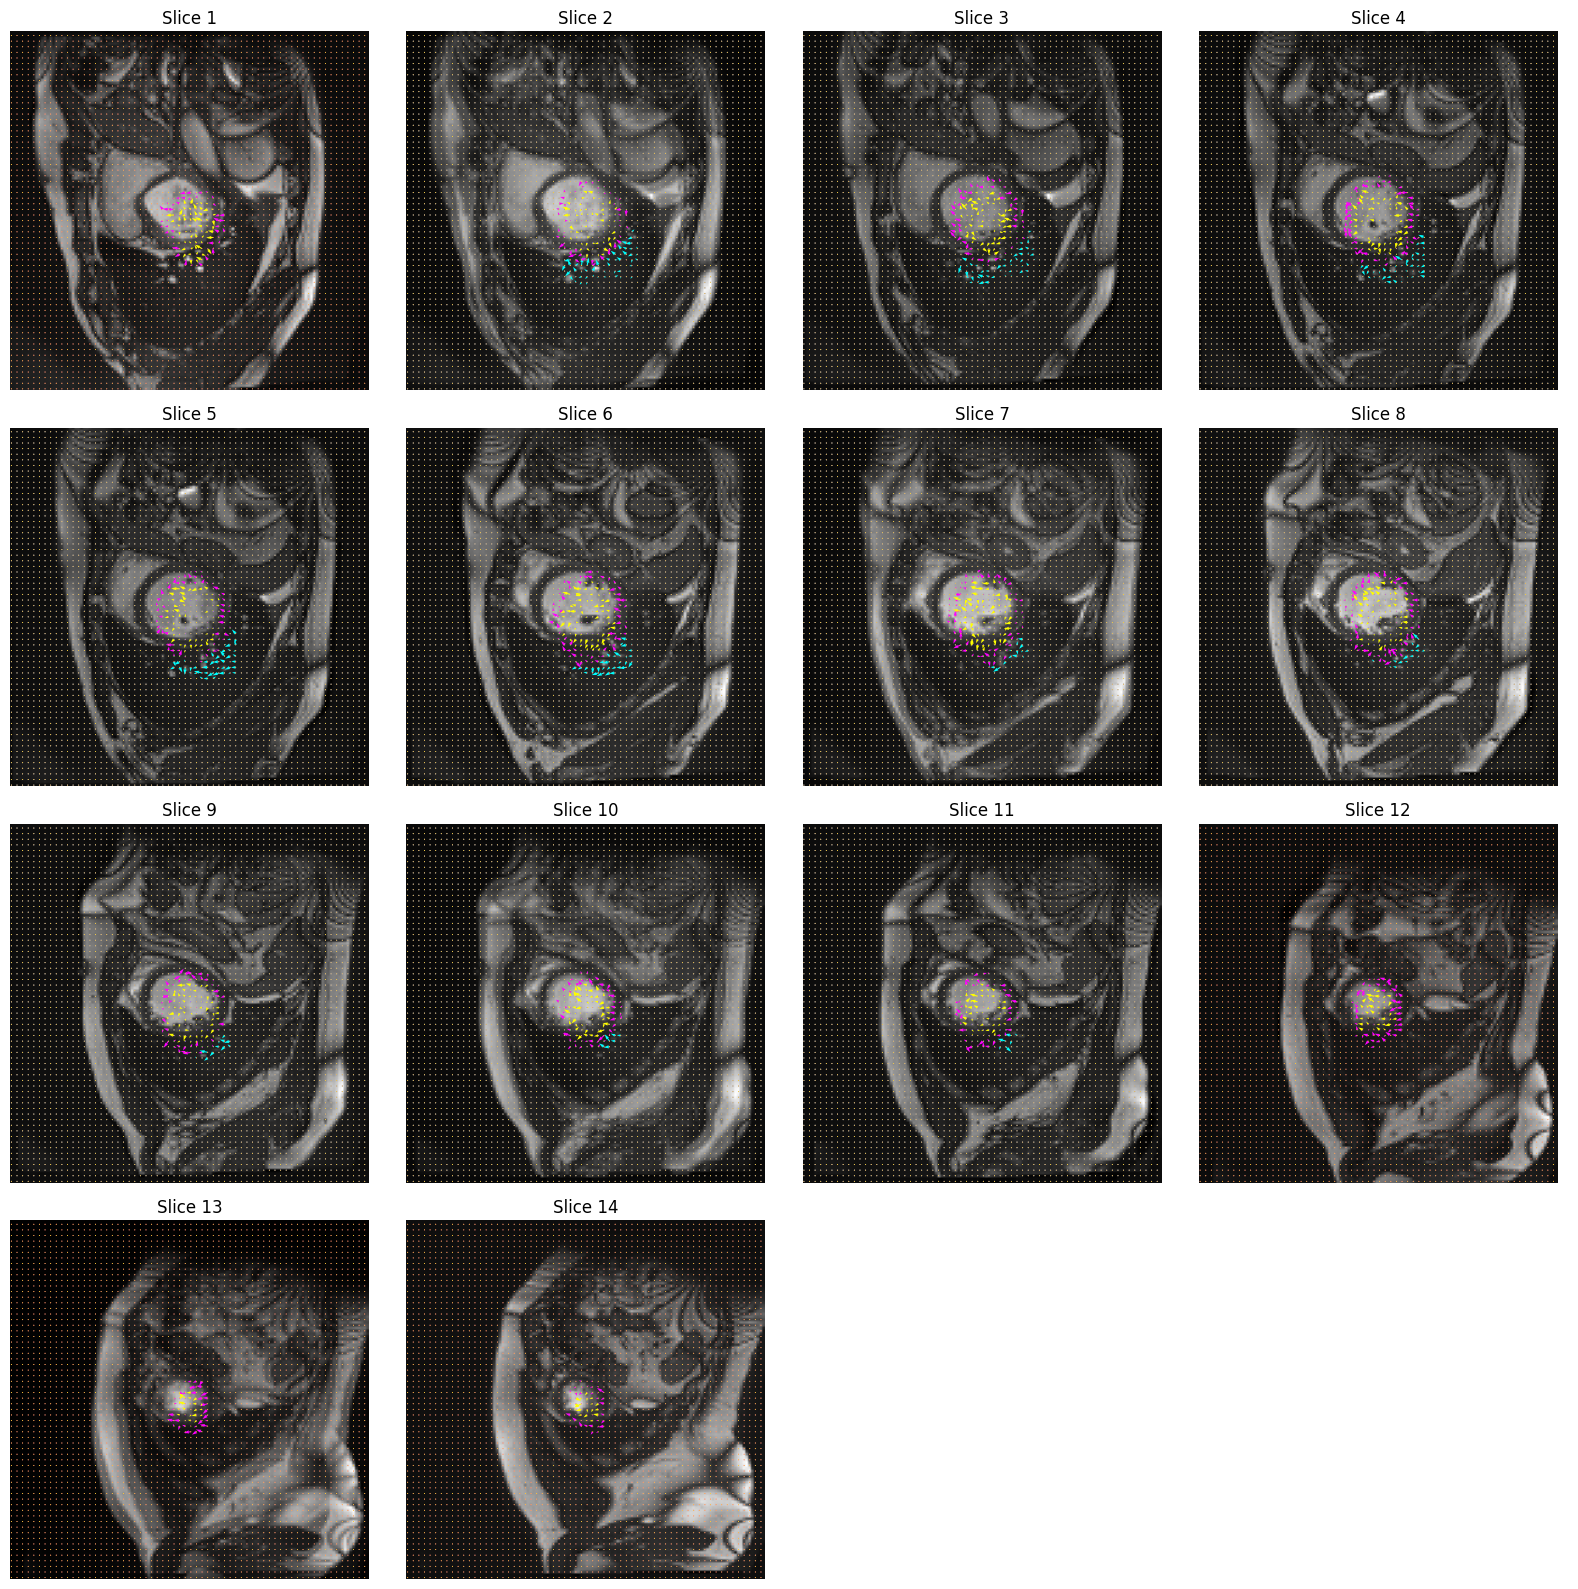

In [4]:
## All classes
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Paths
flow_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/flowf/patient001_flow.npy'
moved_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/moved/patient001_moved.nii.gz'
seg_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/segout/patient001_def_seg.npy'

# Load data
flow = np.load(flow_path)   # shape: (3, H, W, D)
moved = nib.load(moved_path).get_fdata()
seg = np.load(seg_path)     # segmentation: 0=background, 1=myocardium, 2=RV, 3=blood pool

H, W, D = flow.shape[1], flow.shape[2], flow.shape[3]
step = 2     # arrow density
scale_factor = 3

# Labels and colors
labels = {1: 'Myocardium', 2: 'RV', 3: 'Blood pool'}
colors = {1: 'cyan', 2: 'magenta', 3: 'yellow'}

# Determine slices that contain at least one structure
slices_with_labels = [z for z in range(D) if (seg[:, :, z] > 0).any()]

cols = 4
rows = (len(slices_with_labels) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for i, z in enumerate(slices_with_labels):
    ax = axes[i]
    ax.imshow(moved[:, :, z].T, cmap='gray', origin='lower')

    # Extract flow components
    fx = flow[0, :, :, z]
    fy = flow[1, :, :, z]
    X, Y = np.meshgrid(np.arange(W), np.arange(H))

    # Plot arrows for each structure
    for label, name in labels.items():
        mask = (seg[:, :, z] == label)
        if mask.sum() == 0:
            continue

        U = fx * mask
        V = fy * mask
        # Subsample for arrows
        U_ds = U[::step, ::step]
        V_ds = V[::step, ::step]
        X_ds = X[::step, ::step]
        Y_ds = Y[::step, ::step]

        # Scale arrows for visibility
        mag = np.sqrt(U_ds**2 + V_ds**2)
        if mag.max() > 0:
            U_ds = U_ds / mag.max() * scale_factor
            V_ds = V_ds / mag.max() * scale_factor
            ax.quiver(X_ds, Y_ds, U_ds, V_ds, color=colors[label],
                      angles='xy', scale_units='xy', scale=1, width=0.003)

    ax.set_title(f'Slice {z}')
    ax.axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

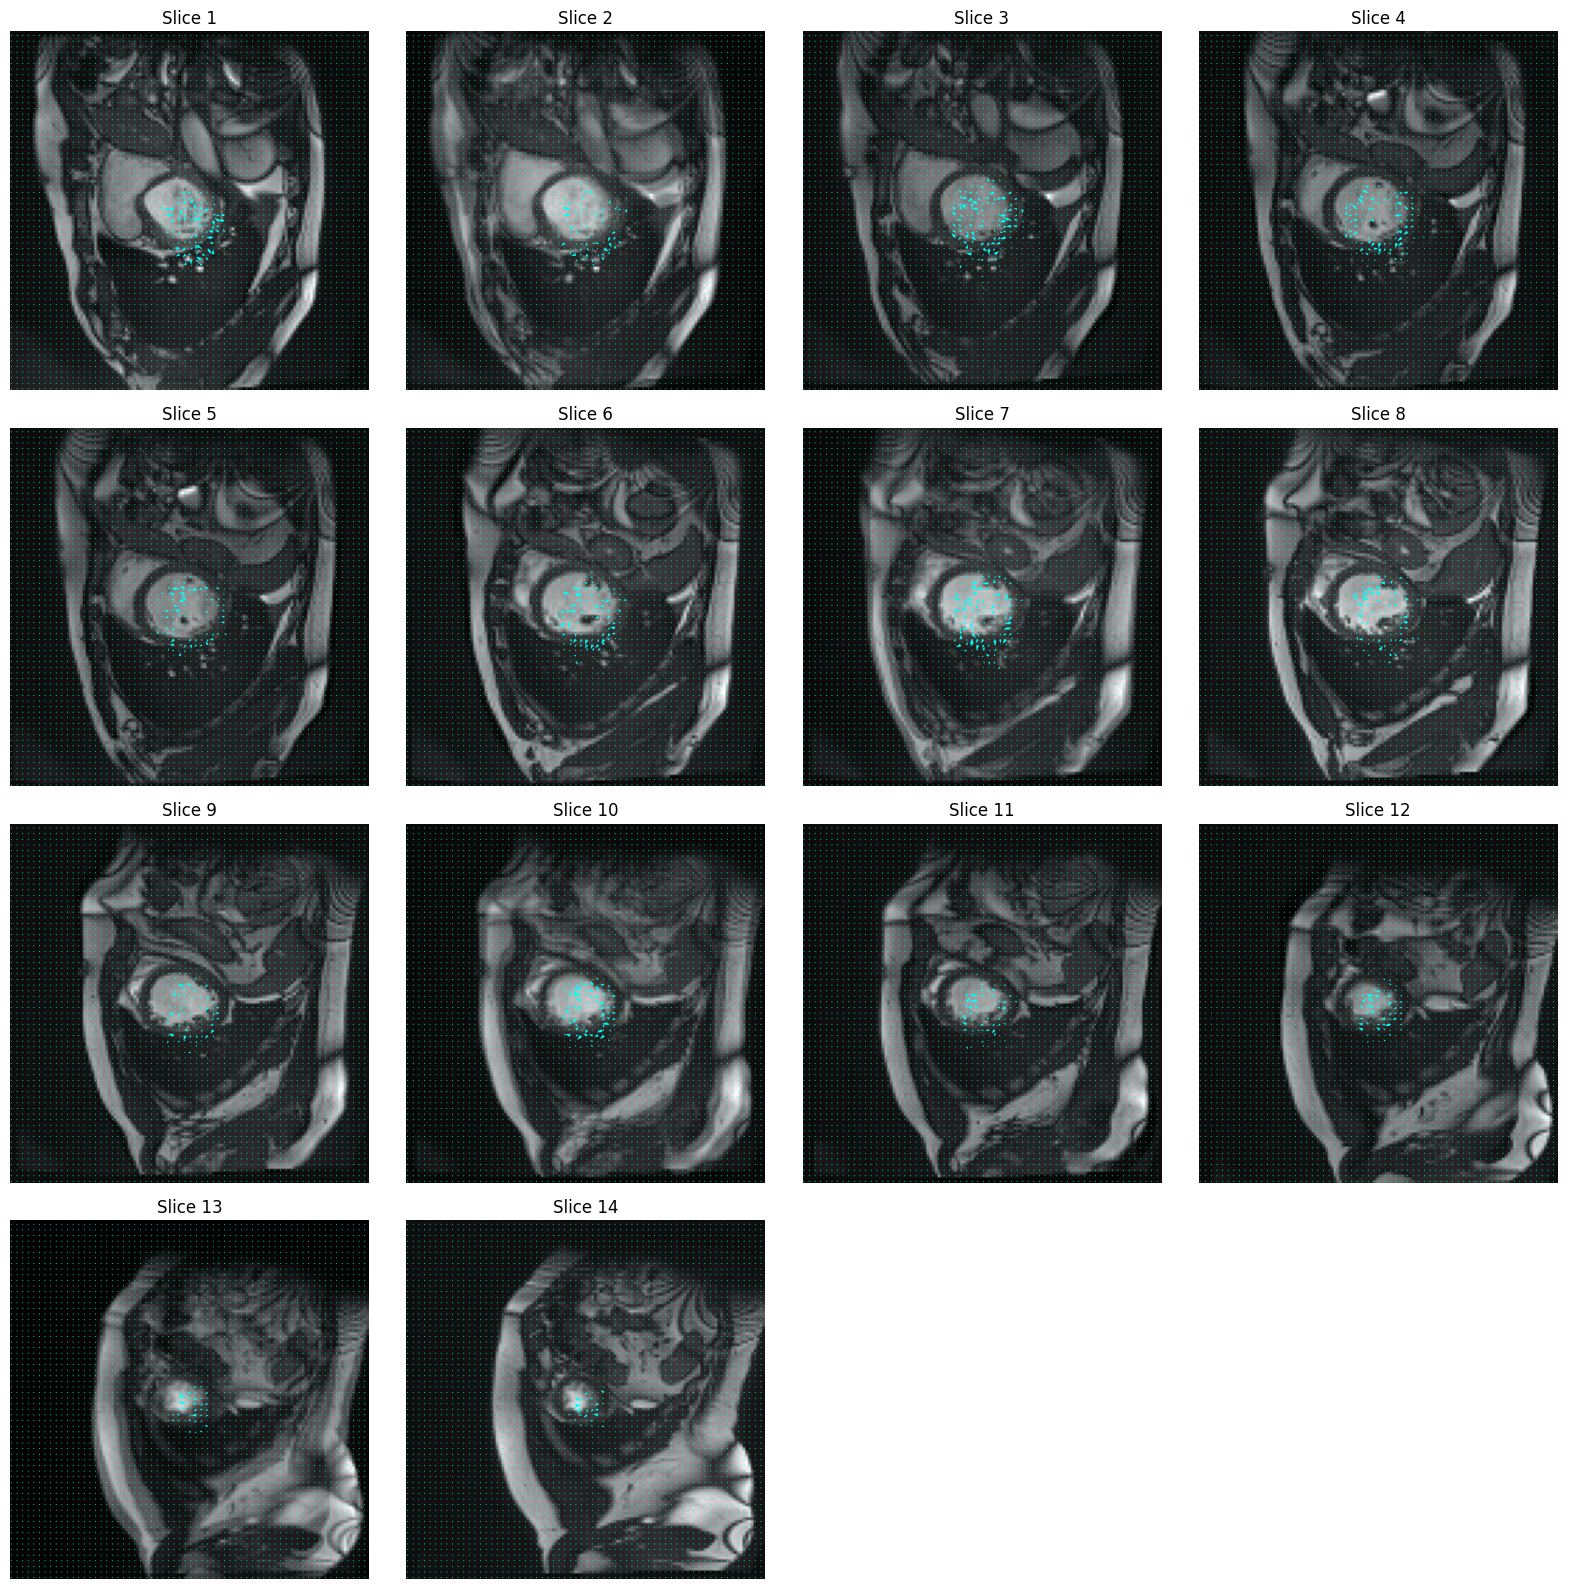

In [5]:
### Myocardium border only
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Paths
flow_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/flowf/patient001_flow.npy'
fixed_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/moved/patient001_moved.nii.gz'
mask_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/segout/patient001_def_seg.npy'  # myocardium mask = 1

# Load data
flow = np.load(flow_path)   # (3,H,W,D)
fixed = nib.load(fixed_path).get_fdata()
mask = np.load(mask_path)   # same HxWxD, myocardium = 1

H, W, D = flow.shape[1], flow.shape[2], flow.shape[3]
step = 2     # denser arrows
scale_factor = 3

# Determine slices with myocardium
slices_with_myocardium = [z for z in range(D) if mask[:, :, z].sum() > 0]

cols = 4
rows = (len(slices_with_myocardium) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for i, z in enumerate(slices_with_myocardium):
    ax = axes[i]

    # Show fixed image
    ax.imshow(fixed[:, :, z].T, cmap='gray', origin='lower')

    # Extract flow
    fx = flow[0, :, :, z] * mask[:, :, z]
    fy = flow[1, :, :, z] * mask[:, :, z]

    # Subsample
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    X_ds = X[::step, ::step]
    Y_ds = Y[::step, ::step]
    U_ds = fx[::step, ::step]
    V_ds = fy[::step, ::step]

    # Scale arrows for visibility
    mag = np.sqrt(U_ds**2 + V_ds**2)
    max_len = mag.max() + 1e-8
    U_ds = U_ds / max_len * scale_factor
    V_ds = V_ds / max_len * scale_factor

    # Plot arrows in cyan
    ax.quiver(X_ds, Y_ds, U_ds, V_ds, color='cyan', angles='xy', scale_units='xy', scale=1, width=0.003)
    ax.set_title(f'Slice {z}')
    ax.axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

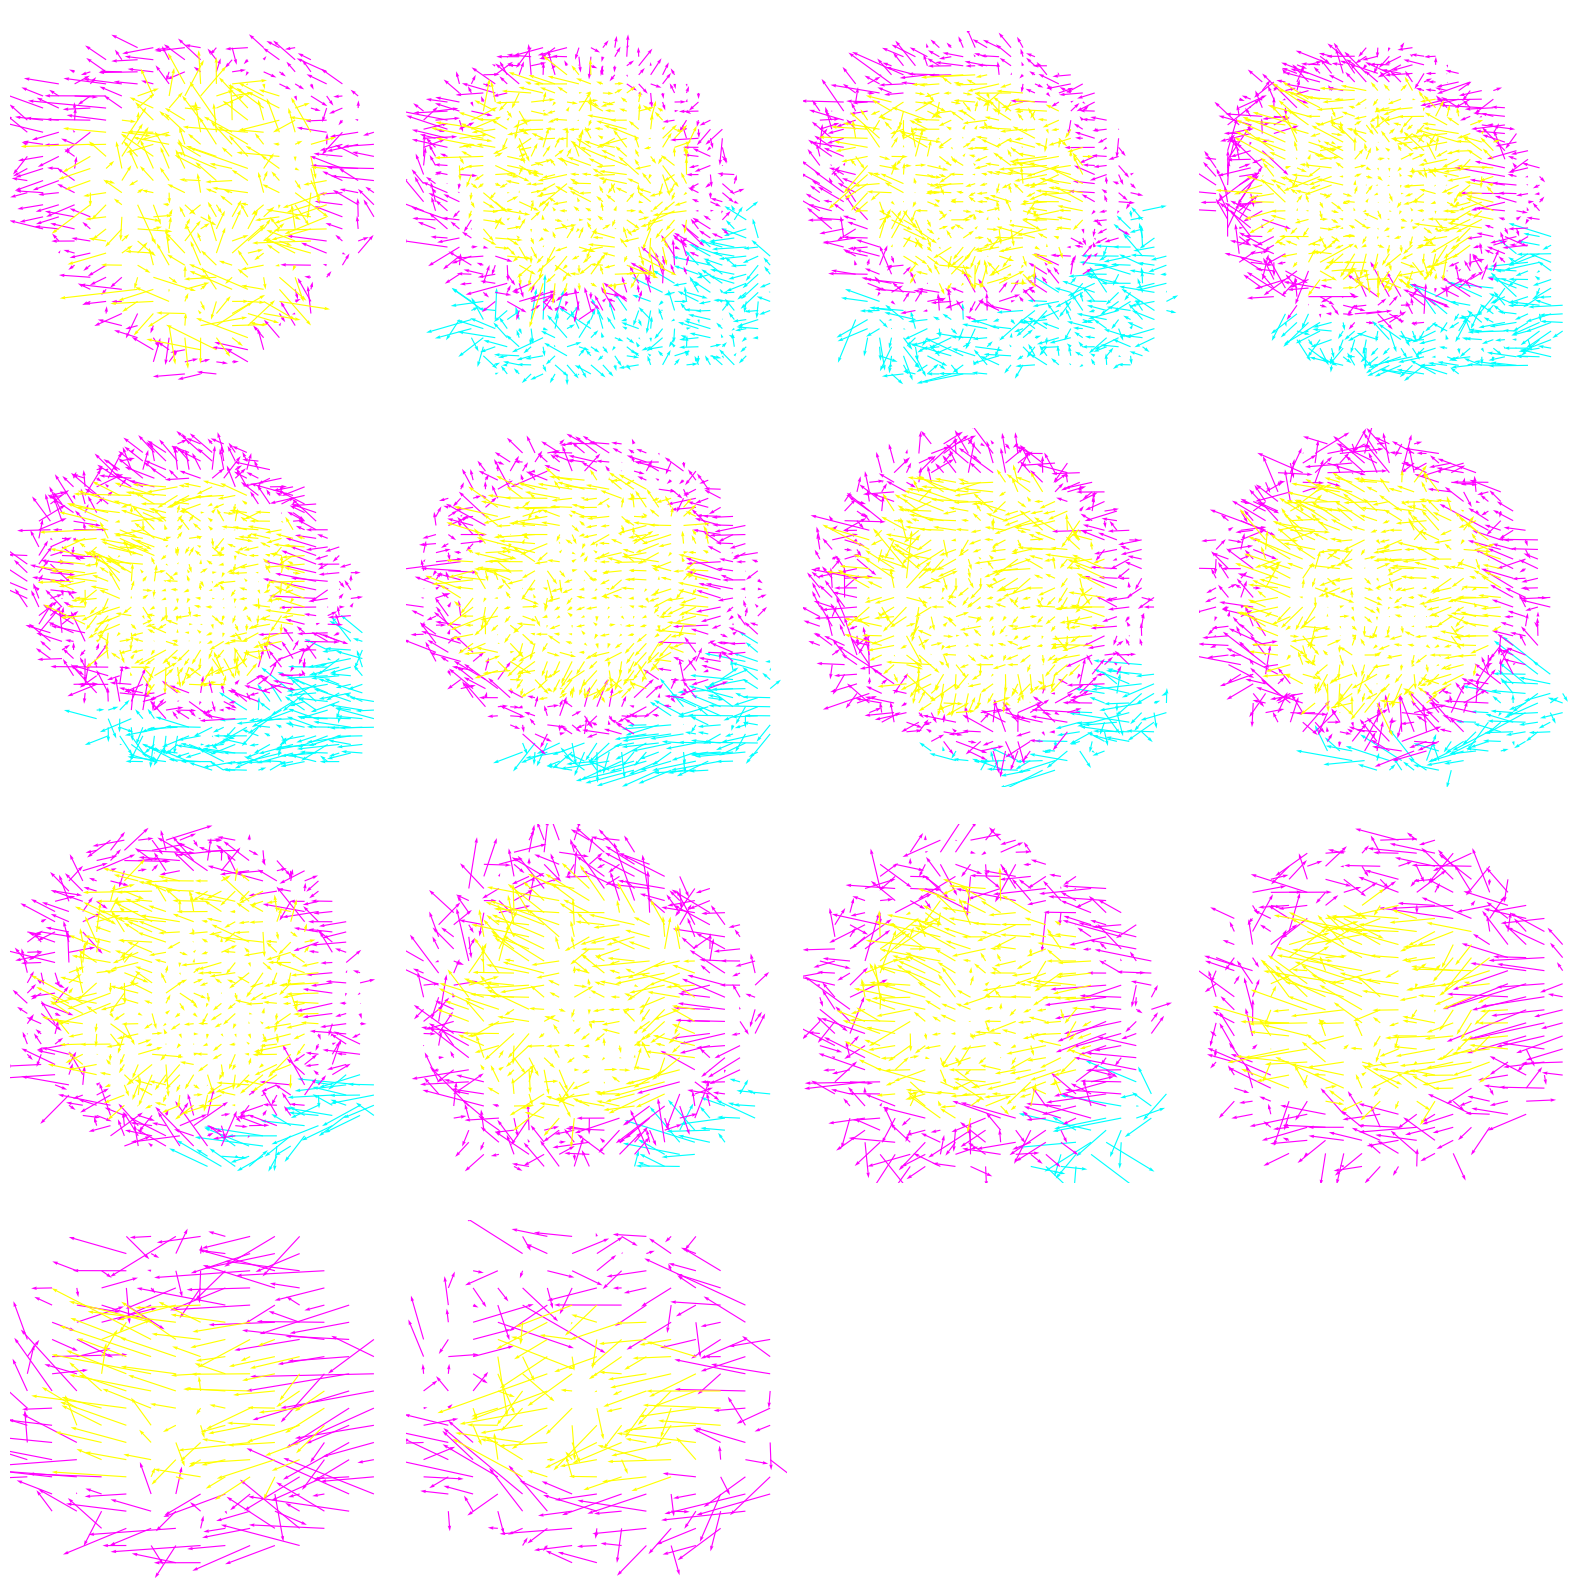

In [6]:
## flow on deformation segmentation
import numpy as np
import matplotlib.pyplot as plt

# Load flow
flow_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/flowf/patient001_flow.npy'
flow = np.load(flow_path)  # shape: (3, H, W, D)

# Load segmentation mask
mask_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/segout/patient001_def_seg.npy'
mask = np.load(mask_path)  # shape: (H, W, D), labels 1,2,3

H, W, D = flow.shape[1], flow.shape[2], flow.shape[3]

step = 4          # arrow density
scale_factor = 5  # arrow length scaling
colors = {1: 'cyan', 2: 'magenta', 3: 'yellow'}

# Find slices with any labeled region
slices_with_labels = [z for z in range(D) if np.any(mask[:, :, z] > 0)]
num_slices = len(slices_with_labels)

# Determine subplot grid
cols = 4
rows = (num_slices + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for i, z in enumerate(slices_with_labels):
    ax = axes[i]
    ax.set_facecolor('black')

    for label in [1,2,3]:
        y_idx, x_idx = np.where(mask[:, :, z] == label)
        if len(x_idx) == 0:
            continue

        u = flow[0, y_idx, x_idx, z]
        v = flow[1, y_idx, x_idx, z]

        # Normalize arrows
        max_len = np.sqrt(u**2 + v**2).max() + 1e-8
        u = u / max_len * scale_factor
        v = v / max_len * scale_factor

        ax.quiver(x_idx, y_idx, u, v, color=colors[label], angles='xy', scale_units='xy', scale=1, width=0.003, label=f'Label {label}')

    ax.set_title(f'Slice {z}', color='white')
    ax.axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


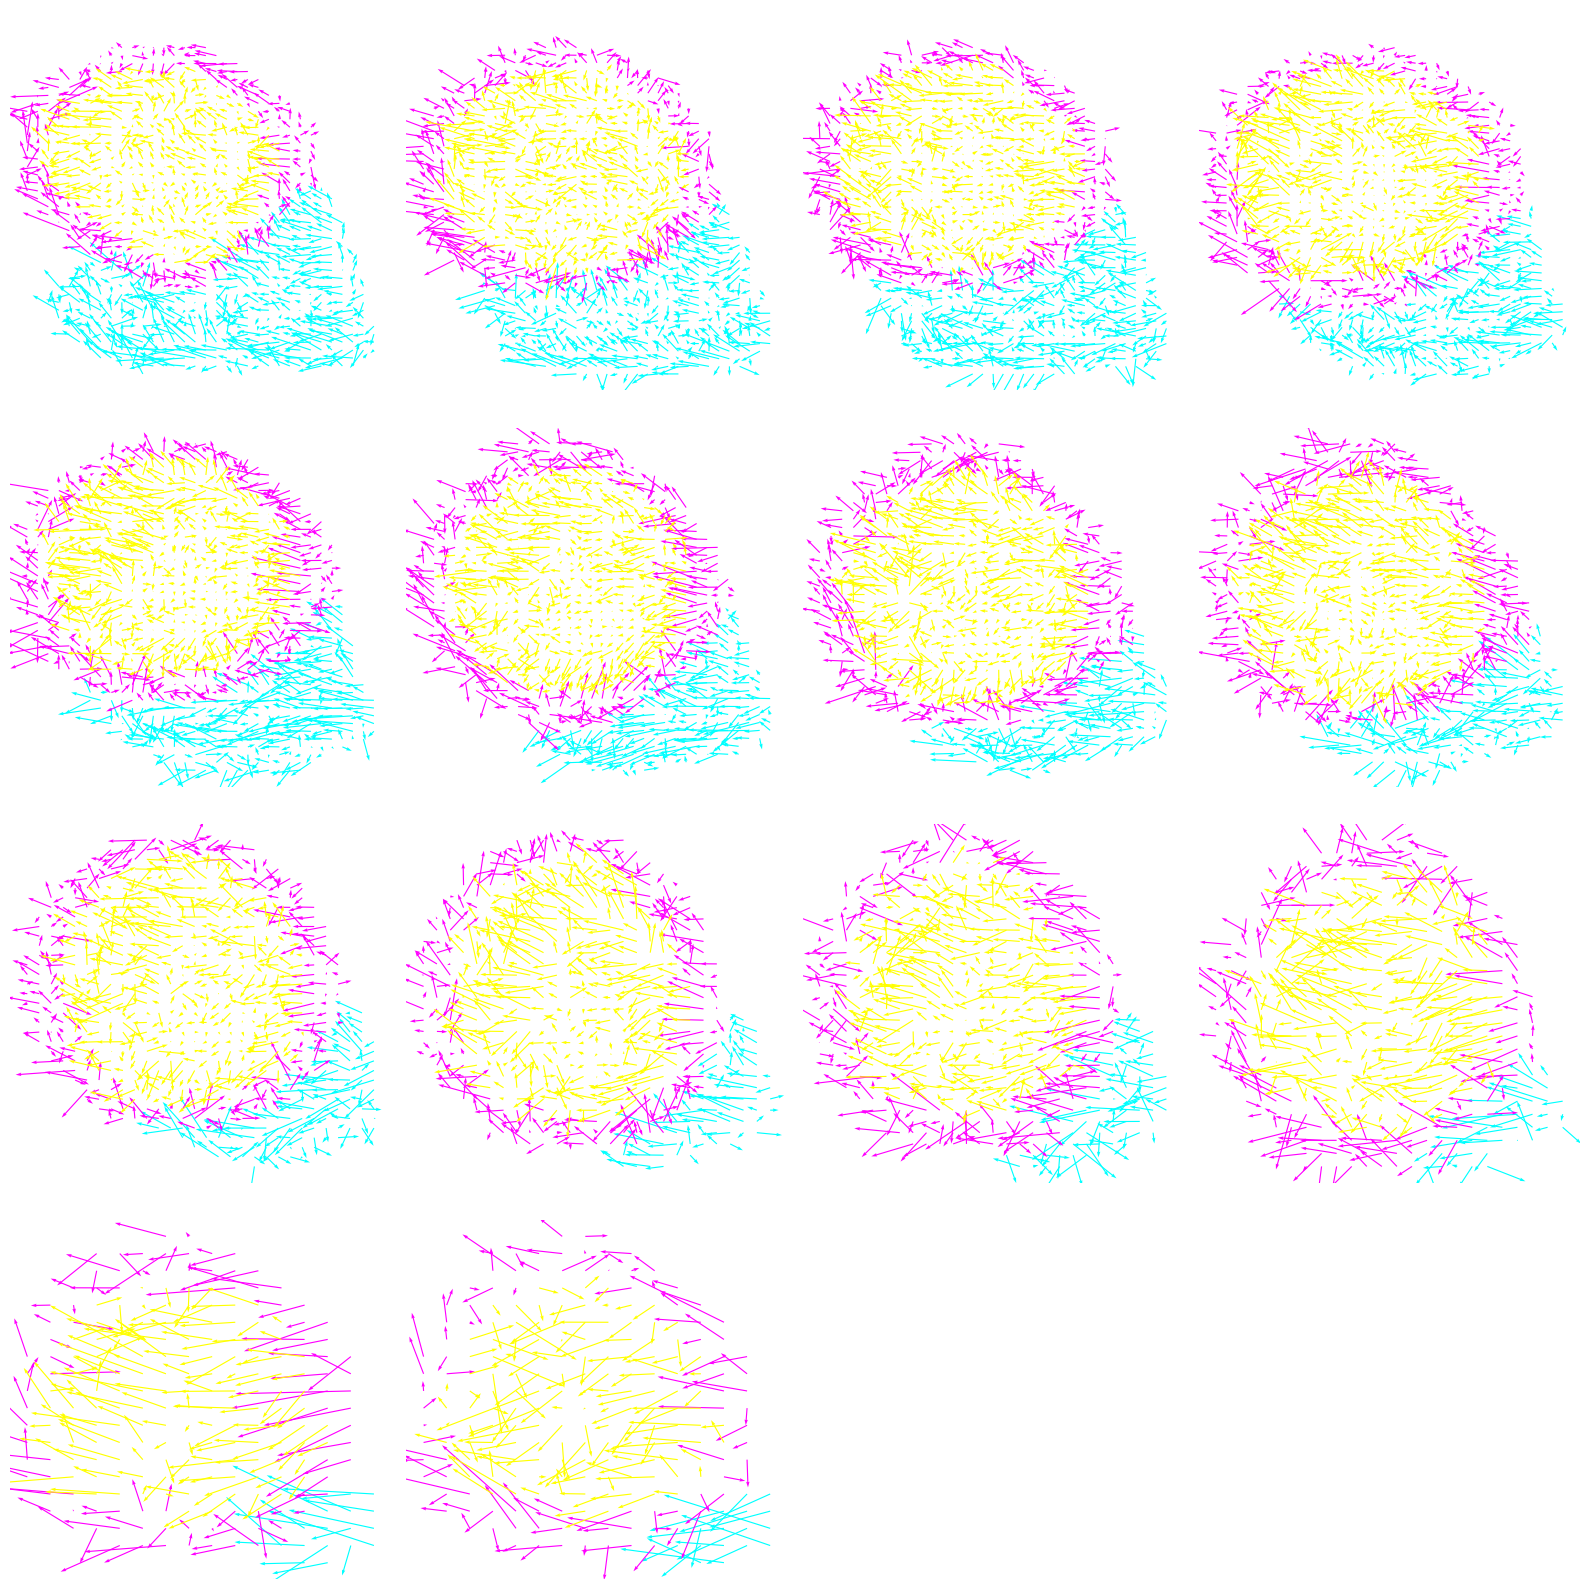

In [7]:
## flow on  fixed segmentation
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
# Load flow
flow_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/flowf/patient001_flow.npy'
flow = np.load(flow_path)  # shape: (3, H, W, D)

# Load segmentation mask
mask_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/fixed_label/patient001_fixed_label.nii.gz'

mask = nib.load(mask_path).get_fdata()  # shape: (H, W, D), labels 1,2,3

H, W, D = flow.shape[1], flow.shape[2], flow.shape[3]

step = 4          # arrow density
scale_factor = 5  # arrow length scaling
colors = {1: 'cyan', 2: 'magenta', 3: 'yellow'}

# Find slices with any labeled region
slices_with_labels = [z for z in range(D) if np.any(mask[:, :, z] > 0)]
num_slices = len(slices_with_labels)

# Determine subplot grid
cols = 4
rows = (num_slices + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for i, z in enumerate(slices_with_labels):
    ax = axes[i]
    ax.set_facecolor('black')

    for label in [1,2,3]:
        y_idx, x_idx = np.where(mask[:, :, z] == label)
        if len(x_idx) == 0:
            continue

        u = flow[0, y_idx, x_idx, z]
        v = flow[1, y_idx, x_idx, z]

        # Normalize arrows
        max_len = np.sqrt(u**2 + v**2).max() + 1e-8
        u = u / max_len * scale_factor
        v = v / max_len * scale_factor

        ax.quiver(x_idx, y_idx, u, v, color=colors[label], angles='xy', scale_units='xy', scale=1, width=0.003, label=f'Label {label}')

    ax.set_title(f'Slice {z}', color='white')
    ax.axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

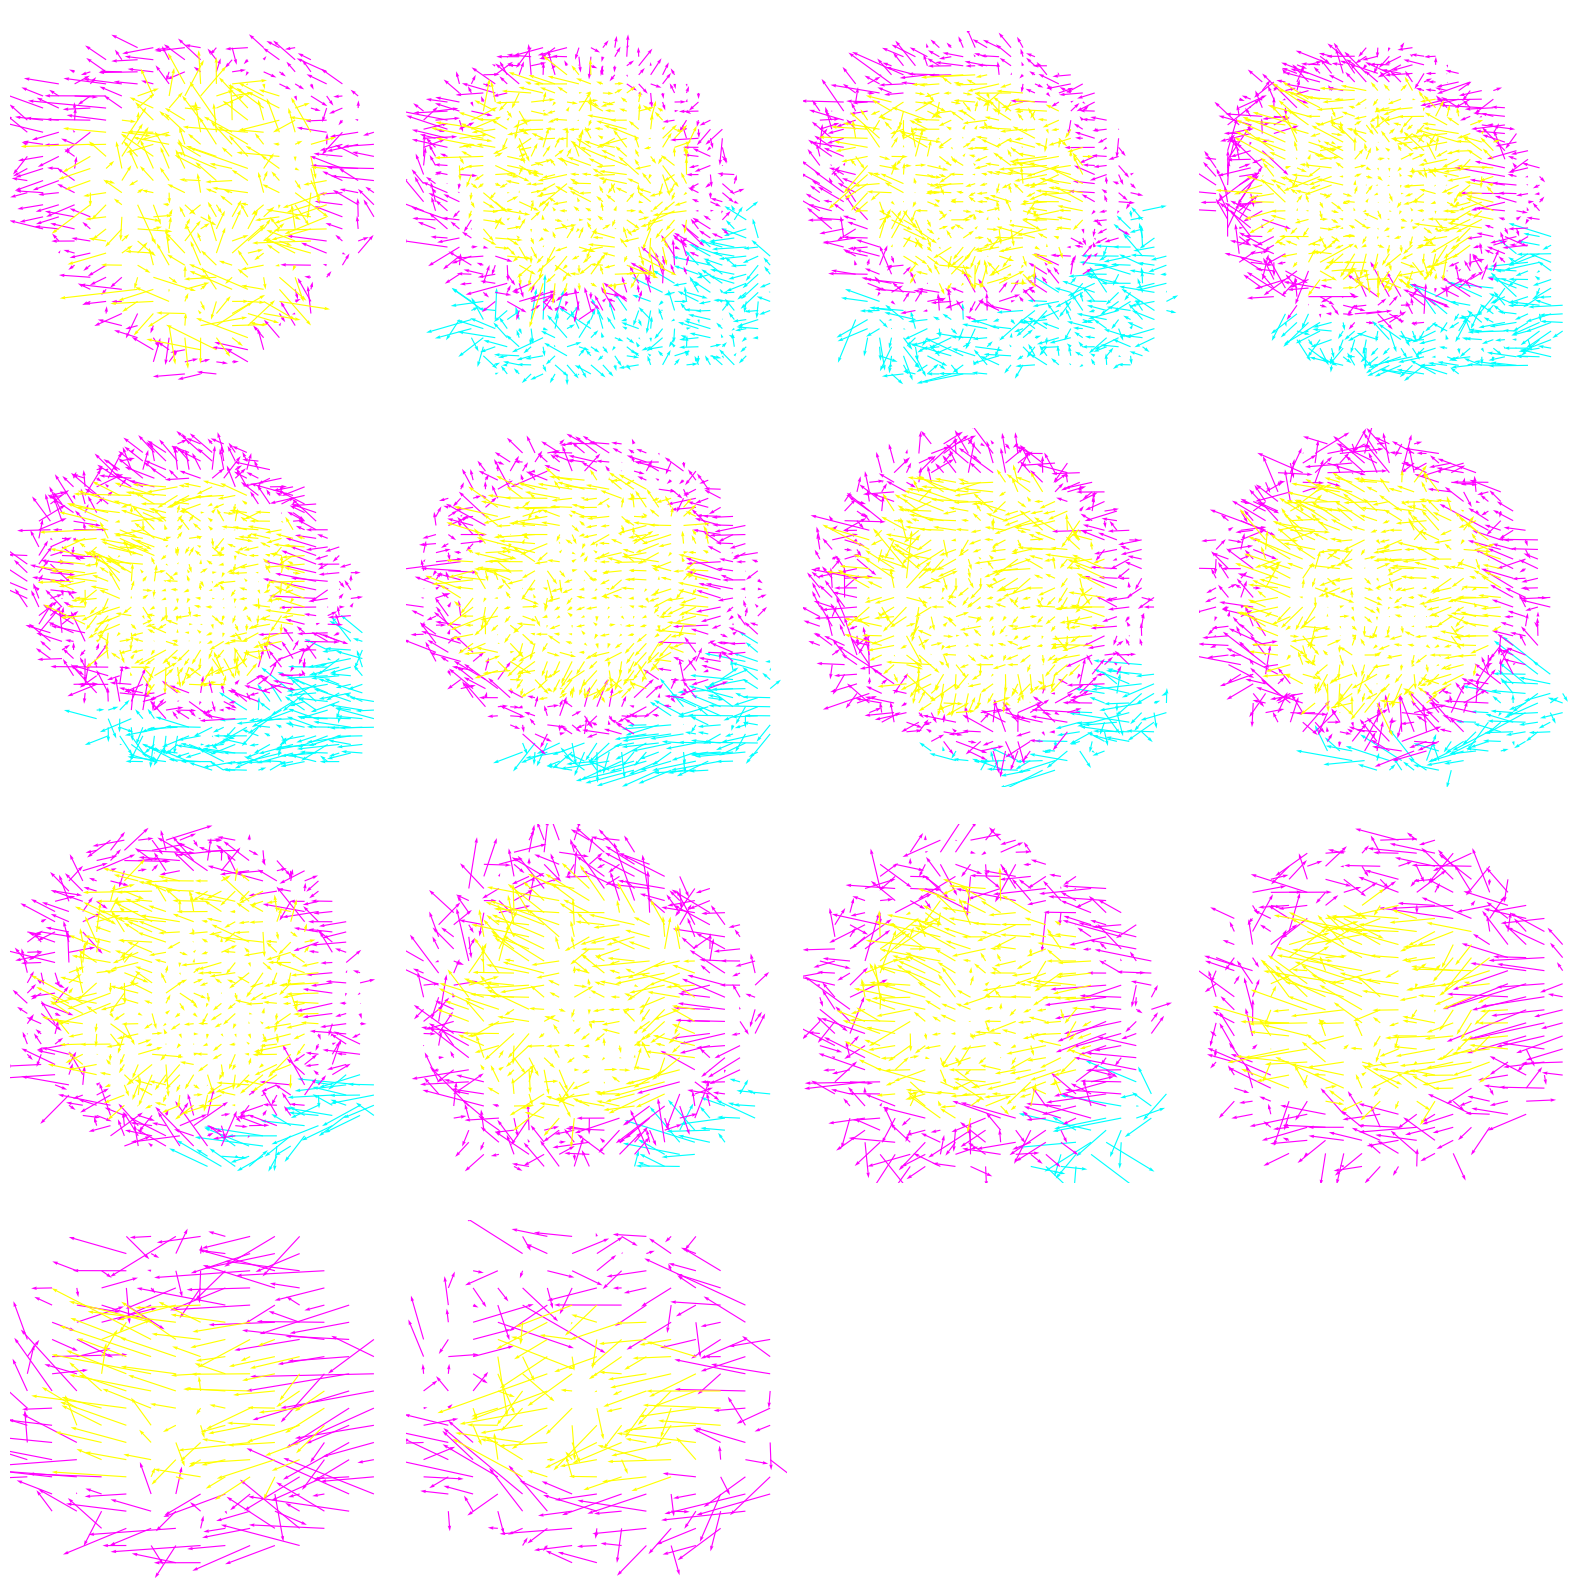

In [8]:
## flow on  fixed segmentation
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
# Load flow
flow_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/flowf/patient001_flow.npy'
flow = np.load(flow_path)  # shape: (3, H, W, D)

# Load segmentation mask
mask_path = '/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/move_label/patient001_moving_label.nii.gz'

mask = nib.load(mask_path).get_fdata()  # shape: (H, W, D), labels 1,2,3

H, W, D = flow.shape[1], flow.shape[2], flow.shape[3]

step = 4          # arrow density
scale_factor = 5  # arrow length scaling
colors = {1: 'cyan', 2: 'magenta', 3: 'yellow'}

# Find slices with any labeled region
slices_with_labels = [z for z in range(D) if np.any(mask[:, :, z] > 0)]
num_slices = len(slices_with_labels)

# Determine subplot grid
cols = 4
rows = (num_slices + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

for i, z in enumerate(slices_with_labels):
    ax = axes[i]
    ax.set_facecolor('black')

    for label in [1,2,3]:
        y_idx, x_idx = np.where(mask[:, :, z] == label)
        if len(x_idx) == 0:
            continue

        u = flow[0, y_idx, x_idx, z]
        v = flow[1, y_idx, x_idx, z]

        # Normalize arrows
        max_len = np.sqrt(u**2 + v**2).max() + 1e-8
        u = u / max_len * scale_factor
        v = v / max_len * scale_factor

        ax.quiver(x_idx, y_idx, u, v, color=colors[label], angles='xy', scale_units='xy', scale=1, width=0.003, label=f'Label {label}')

    ax.set_title(f'Slice {z}', color='white')
    ax.axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()